# Food and Agricultural Trends

**Team Papillon**

Nowadays, environmental problems are becoming more and more serious and urgent to deal with. We cannot deny the impact of food and agriculture in general, on the environment. If we consider what we eat and how we grow it, we would find extensive damage to the environment (green gas emissions, soil depletion etc.) and also the wildlife (due to pesticides, fertilizers etc.). We are looking to use the data provided by FAOSTAT giving access to over 3 million time-series and cross sectional data relating to food and agriculture all over the world and try to generate insights and stories on the evolution of different socio-environmental factors such as the correlation between greenhouse gas emissions and agricultural growth for example. Through this work, we hope to gain a deeper insight on the evolution and the environmental impact of agriculture and food.

## Question 1 and 2

### Could we find and support a correlation between greenhouse gas emissions and agricultural growth? Could we also assess the influence of the type of culture on the emissions?
### Based on this, is it possible to make predictions of greenhouse gas emissions by extrapolating the agricultural growth and land usage?

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import statsmodels
import folium
import math

# Custom imports
from ipywidgets import IntProgress
from IPython.display import display
import time
from multiprocessing import Pool, Lock
import os
import json
import seaborn as sns
import time

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing   import StandardScaler

## Importing the data

In order to find a model that helps in the understanding of the role of the variety of crops in the ecological influence of the agriculture, we need 3 datasets:

- The land usage
- The crops cultures
- The emissions related to the agriculture


In [2]:
dataLands = pd.read_csv("./data/fao_data_land_data.csv")

dataCrops = pd.read_csv("./data/fao_data_crops_data.csv")

dataEmissions = pd.read_csv("./data/current_FAO/raw_files/Environment_Emissions_by_Sector_E_All_Data_(Normalized).csv", encoding="cp1252")

## Cleaning

- Removing NAN
- Removing useless columns

In [3]:
dataLands = dataLands.dropna(subset=["element"])

dataCrops = dataCrops.dropna(subset=["element"])

dataEmissionsAgriculture = dataEmissions.where(dataEmissions["Item"] == "Agriculture total").where(dataEmissions["Element"] == "Emissions (CO2eq)").dropna()
dataEmissionsAgriculture = dataEmissionsAgriculture.drop(["Item", "Element Code", "Element", "Item Code", "Year Code", "Flag"], axis=1)\
                                                    .rename(columns={"Unit":"Unit emissions","Value":"Value emissions"})

Here is a graph that shows the progression of land usage within each continent.

/home/jeremy/miniconda3/envs/ada-2019/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


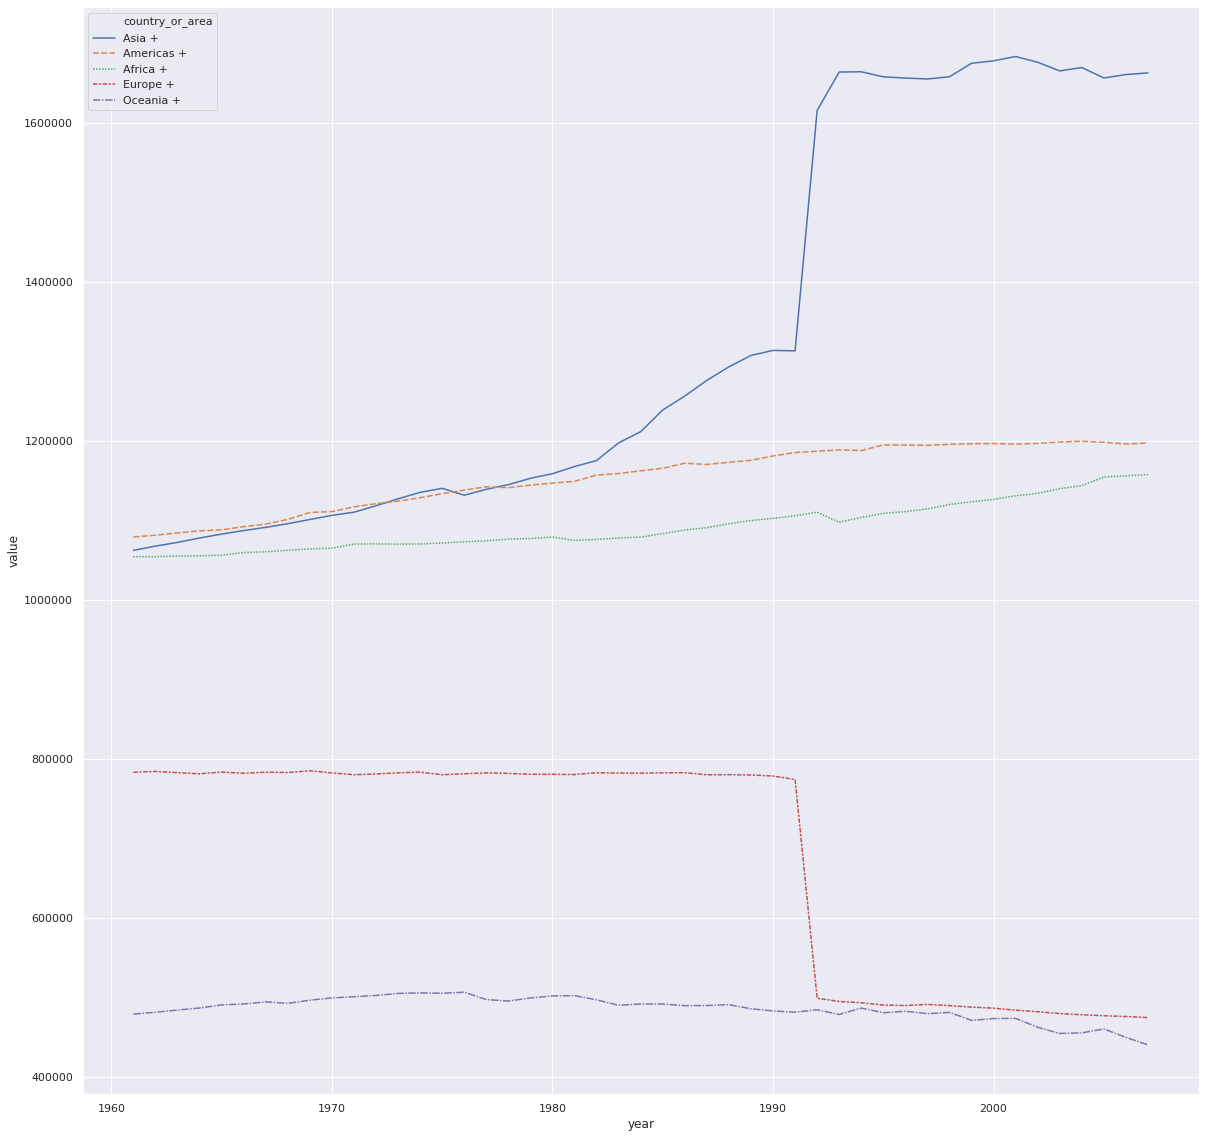

In [4]:
def cond_countries(dataLands):
    countries = ["Asia +","Europe +", "Americas +", "Oceania +", "Africa +"]
    truthTable = (dataLands["country_or_area"] == countries[0])
    for c in countries:
        truthTable = (dataLands["country_or_area"] == c) | truthTable
    return truthTable

dataLandsContinent = dataLands.where(dataLands["category"] == "agricultural_area")\
                                .where(cond_countries(dataLands))\
                                .dropna(subset=["country_or_area"])\
                                .sort_values("value",ascending=False)

sns.set(style="darkgrid")

fg = plt.figure(figsize=(20,20))
axes = fg.add_subplot()
# Plot the responses for different events and regions
sns.lineplot(x="year", y="value", style="country_or_area", data=dataLandsContinent, hue="country_or_area", ax=axes)

fg.show()

Here are the emissions of the BRICS throughout the years. We can see a clear progression (except for South Africa).

/home/jeremy/miniconda3/envs/ada-2019/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


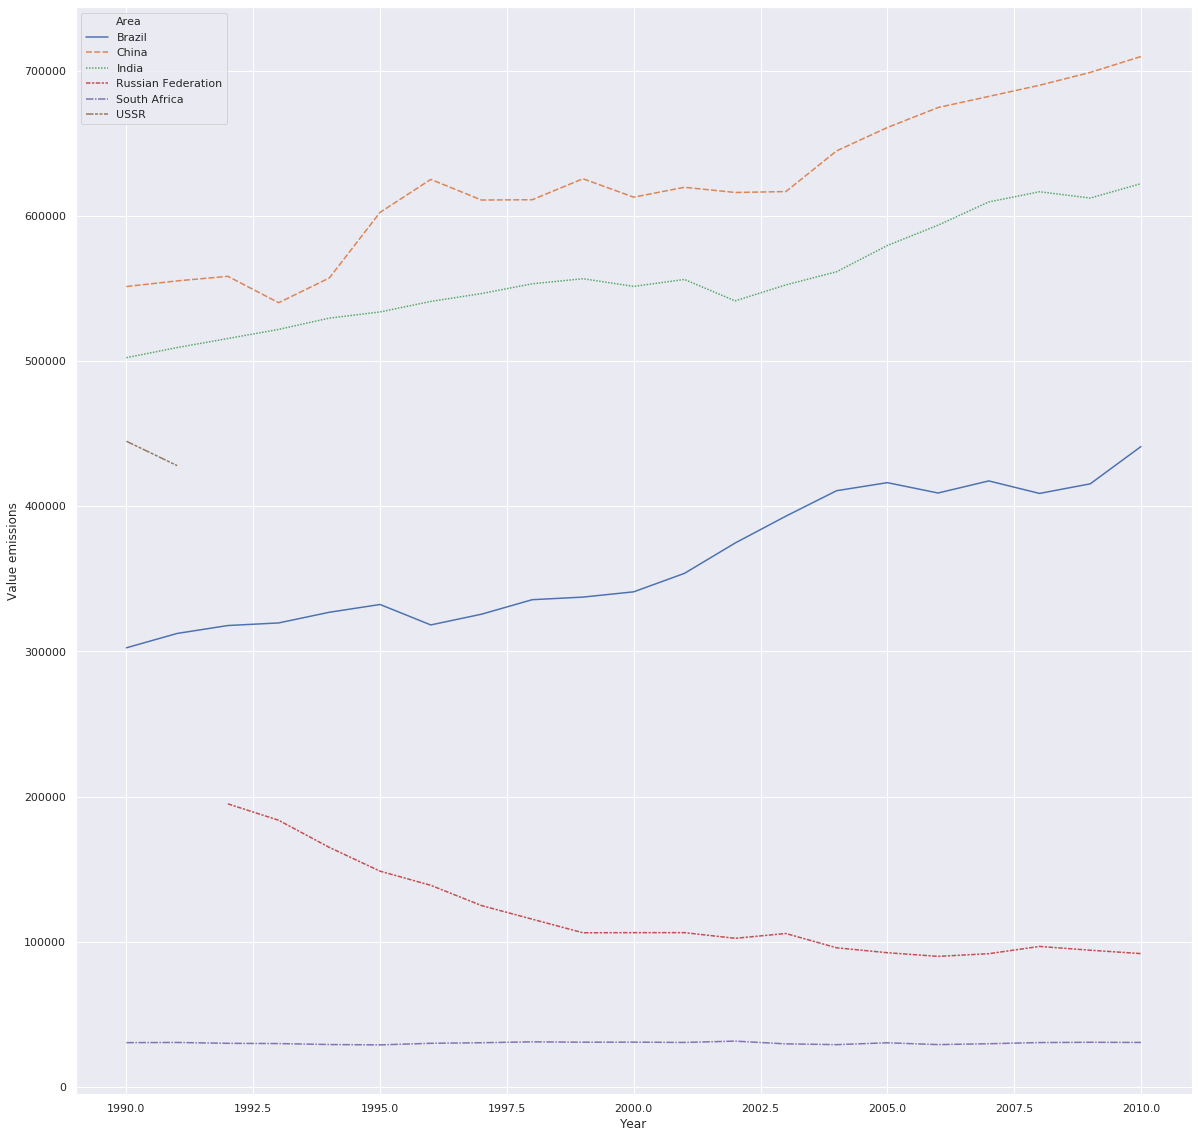

In [5]:
sns.set(style="darkgrid")

dataEmissionsAgrContinent = dataEmissionsAgriculture.where(dataEmissionsAgriculture["Area"].isin(["South Africa","Brazil", "China", "India", "USSR","Russian Federation"])).dropna()

fg = plt.figure(figsize=(20,20))
axes = fg.add_subplot()
# Plot the responses for different events and regions
sns.lineplot(x="Year", y="Value emissions", style="Area", data=dataEmissionsAgrContinent, hue="Area", ax=axes)

fg.show()

## Creating the dataset for processing

The dataset we create for processing consist in the aggregation of the area harvested of for each crop, by year and by country, and the emissions of greenhouse gases by year and by country as well. The goal will be to find a model that explain and helps in predicting the emissions, based on the other features (country, year and crops).

In [6]:
cropsAndEmissions = dataCrops.drop(["element_code"], axis=1)\
                                .where(dataCrops["element"] == "Area Harvested")\
                                .dropna(subset=["element"])\
                                .drop(["element", "value_footnotes"],axis=1)\
                                .rename(columns={"unit":"Unit area", "value":"Value area", "year":"Year","country_or_area":"Area"})
#                                .where(dataCrops["country_or_area"] == "World +")\
cropsAndEmissions = cropsAndEmissions.pivot_table(values='Value area',index=["Area","Year"],columns="category").reset_index()
cropsAndEmissions = cropsAndEmissions.fillna(0)
cropsAndEmissions = pd.merge(cropsAndEmissions, dataEmissionsAgriculture, how="left", on=['Area',"Year"])#.dropna(subset=["Value area", "Value emissions"])
cropsAndEmissions = cropsAndEmissions.dropna().dropna(subset=["Unit emissions"])
cropsAndEmissions

,Area,Year,agave_fibres_nes,almonds_with_shell,anise_badian_fennel_corian,apples,apricots,arecanuts,artichokes,asparagus,...,vegetables_melons_total,vetches,walnuts_with_shell,watermelons,wheat,yams,yautia_cocoyam,Area Code,Unit emissions,Value emissions
29,Afghanistan,1990.0,0.0,5400.0,1300.0,2340.0,5060.0,0.0,0.0,0.0,...,54600.0,0.0,2300.0,8200.0,1570000.0,0.0,0.0,2.0,Gigagrams,7342.7099
30,Afghanistan,1991.0,0.0,5500.0,1300.0,2340.0,5060.0,0.0,0.0,0.0,...,52500.0,0.0,2300.0,7800.0,1690000.0,0.0,0.0,2.0,Gigagrams,7631.0272
31,Afghanistan,1992.0,0.0,5500.0,700.0,2340.0,5060.0,0.0,0.0,0.0,...,52900.0,0.0,2300.0,7800.0,1600000.0,0.0,0.0,2.0,Gigagrams,7631.4427
32,Afghanistan,1993.0,0.0,5500.0,700.0,2300.0,5100.0,0.0,0.0,0.0,...,54900.0,0.0,2300.0,7800.0,1900000.0,0.0,0.0,2.0,Gigagrams,7702.7416
33,Afghanistan,1994.0,0.0,5500.0,700.0,2350.0,5100.0,0.0,0.0,0.0,...,56900.0,0.0,2300.0,7800.0,2000000.0,0.0,0.0,2.0,Gigagrams,7699.1389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10727,Zimbabwe,2003.0,0.0,0.0,200.0,750.0,20.0,0.0,15.0,60.0,...,25937.0,0.0,0.0,0.0,26500.0,0.0,0.0,181.0,Gigagrams,9779.6837
10728,Zimbabwe,2004.0,0.0,0.0,200.0,750.0,20.0,0.0,17.0,60.0,...,26092.0,0.0,0.0,0.0,26300.0,0.0,0.0,181.0,Gigagrams,10470.7635
10729,Zimbabwe,2005.0,0.0,0.0,200.0,900.0,20.0,0.0,17.0,60.0,...,26242.0,0.0,0.0,0.0,28000.0,0.0,0.0,181.0,Gigagrams,9877.5998
10730,Zimbabwe,2006.0,0.0,0.0,200.0,750.0,20.0,0.0,15.0,60.0,...,23502.0,0.0,0.0,0.0,35000.0,0.0,0.0,181.0,Gigagrams,10053.3116


## Learning to predict emissions

Here, we try to create a model by doing a logistic regression on the data. We first try to optimize the alpha parameter on a predefined interval and then we use it to train the model.

Best alpha is 29.032258064516128 with a MSE of 392737681.660032 .


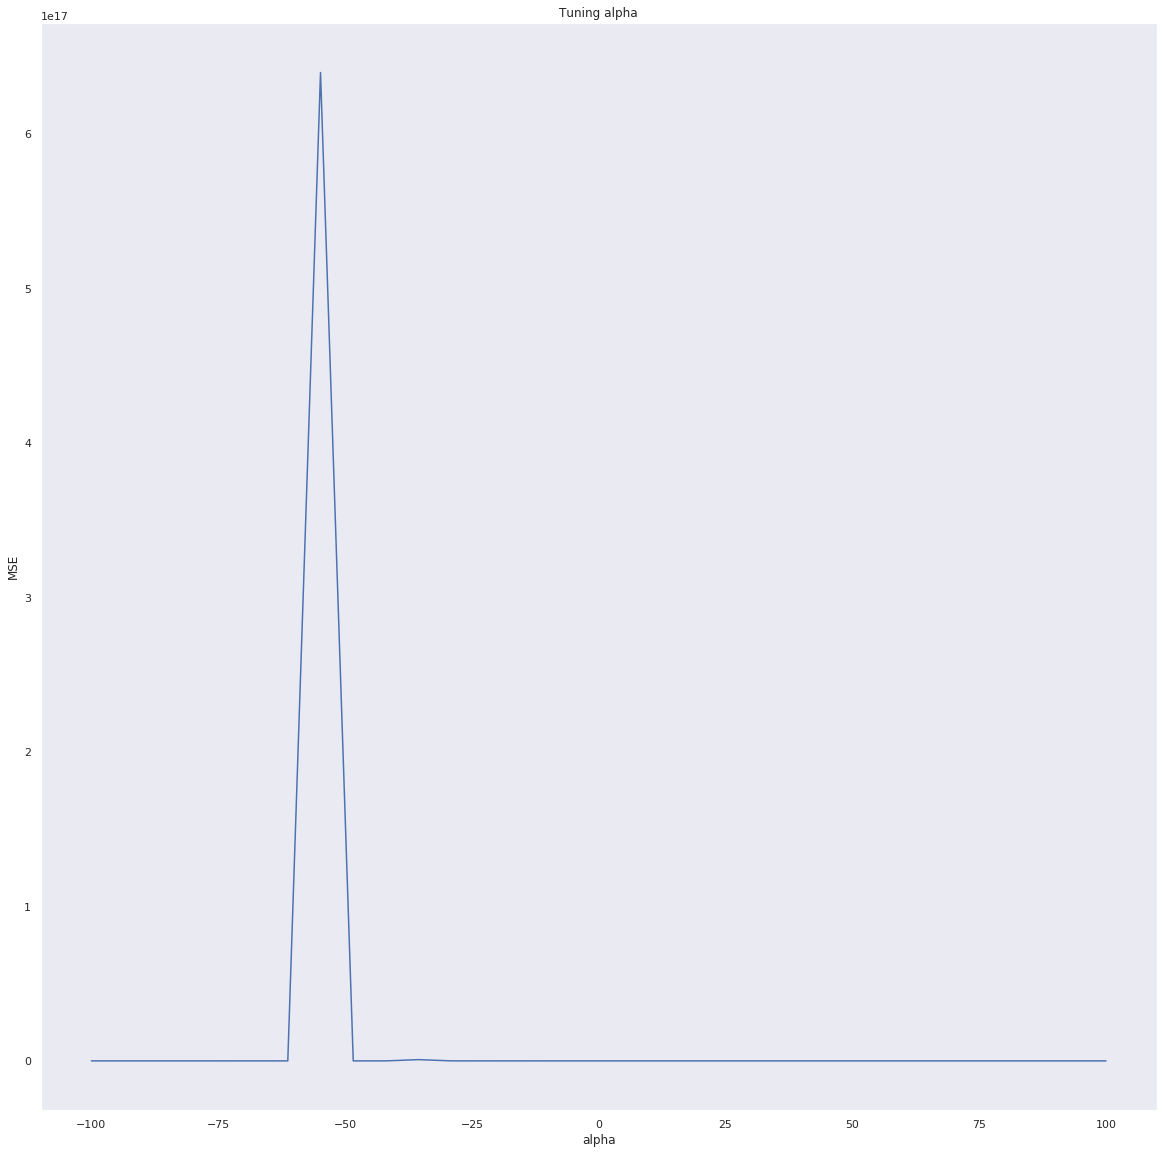

In [7]:
SEED = 1
st_pipeline = Pipeline([('scl', StandardScaler()), ('ridge', Ridge(copy_X=True, random_state=SEED))])
st_pipeline

#features = ["Area","category"]

XRidge2 = pd.get_dummies(cropsAndEmissions.drop(["Area Code","Unit emissions", "Value emissions"], axis=1))
yRidge2 = cropsAndEmissions["Value emissions"]

results = []

# Tune for alpha using 10 fold crossvalidation when calculating the mean squared error.
for alpha in np.linspace(-100, 100, 32):
    st_pipeline.set_params(ridge__alpha= alpha) 
    neg_MSE = cross_val_score(st_pipeline, XRidge2, yRidge2, scoring='neg_mean_squared_error', cv=10)  # we use 10 folds crossvalidation since 10 
                                                                                                      # is pretty much standard in the industry
    results.append([neg_MSE, alpha])
    
# Take the mean MSE for each level of alpha
for i in range(len(results)):
    results[i][0] = -np.mean(results[i][0])
    
# Plot the results
plt.figure(figsize=(20,20))
plt.plot([row[1] for row in results], [row[0] for row in results])
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.title('Tuning alpha');
plt.grid()

best_st_alpha = min(results)[1]
print('Best alpha is', best_st_alpha, 'with a MSE of', min(results)[0],'.')

In [8]:
st_Model = st_pipeline.set_params(ridge__alpha= best_st_alpha)  # use best alpha calculated above
st_Model.fit(XRidge2, yRidge2)                                  # fit the new model

Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('ridge',
                 Ridge(alpha=29.032258064516128, copy_X=True,
                       fit_intercept=True, max_iter=None, normalize=False,
                       random_state=1, solver='auto', tol=0.001))],
         verbose=False)

In [9]:
#st_Model.named_steps["ridge"].coef_
pd.DataFrame([XRidge2.columns,st_Model.named_steps["ridge"].coef_]).transpose().sort_values(1)

,0,1
91,mushrooms_and_truffles,-2158.66
107,other_melons_inc_cantaloupes,-2080.23
356,Area_Ukraine,-1600.37
301,Area_Nigeria,-1505.16
216,Area_Cuba,-1482.57
...,...,...
195,Area_Brazil,3906.77
143,soybeans,3947.84
83,maize,4543.2
179,Area_Australia,6052.34


Further analysis will be conducted in order to create efficient predictions. This first analysis already gave us clear insight of the data and helps us in assessing the feasability of this research.

## Plan

The next steps will be :

- Visualize the output of the model and its relation to reality.
- Try new models and assess their performances.
- Make predictions on the future using these regressions.
- Extract guidelines that could help in reducing emissions in the future, based on these data.
- Criticize these guidelines and the predictions using more domain-related knowledge.

## Question 3

Is it possible to rank some patterns of land usage with social and environmental factors such as employment, life satisfaction (if data are presents), income inequalities (if data are presents), emissions and finally soil quality and sustainability?

To answer this question we will need to acquire additionnal data, but before doing that, we must define the **scope** of the question. It doesn't really make sense to aggregate countries into continents since the social factors are really specific to each country. Therefore, we reduce our scope to a list of 12 countries that we are interested in and feel are important.

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import statsmodels
import folium
import math

# Custom imports
from ipywidgets import IntProgress
from IPython.display import display
import time
from multiprocessing import Pool, Lock
import os
import json
import seaborn as sns
import time

In [ ]:
countries = ['France', 'Canada', 'Germany', 'India', 'Japan', 'Russian Federation', 'Switzerland', 'United States of America', 'United Kingdom', 'China', 'Israel']

## Data acquisition and cleaning

In [ ]:
dataLands = pd.read_csv("./data/fao_data_land_data.csv")
dataLands.head()

In [ ]:
# investigate NaN values
dataLands[np.isnan(dataLands['value'].values)].head(3)

We observe that the dataset is pretty clean. The only NaNs in 'value' column are actually the footnotes so we can drop them.

In [ ]:
dataLands = dataLands.dropna(subset=["value"])
dataLands.tail(3)

In [ ]:
print(dataLands['category'].unique().tolist())

# we only keep agricultural area
dataLands = dataLands[dataLands['category'] == 'agricultural_area']

In [ ]:
# let's observe the temporal evolution of agricultural lands for our selected countries

def check_country(countries, DF):
    """Checks wether the countries 'countries' are in the dataframe.series DF"""
    for country in countries:
        if country not in DF.unique():
            print('Country', country, 'is missing!')
        
check_country(countries, dataLands['country_or_area'])

# reduce subset to selected countries
rdataLands = dataLands.loc[dataLands['country_or_area'].isin(countries)]

# groupe by country
grdataLands = rdataLands.groupby('country_or_area')

plt.figure(figsize=(15,15))
for country in countries:
    # we normalize the total land area by devinding by its mean
    sns.lineplot(x=grdataLands.get_group(country).year, y=grdataLands.get_group(country).value/np.mean(grdataLands.get_group(country).value), label=country)
    
plt.ylabel('land area / mean land area')
plt.title('Relative evolution of agricultural land areas');

We observe an overall downward trend the agricultutral land areas except for a few countries (India and China). However, we also notice an anomally with Russia that must be investigated: no data is present before 1991.

After some research we found out that the dissolution of the Soviet Union (USSR) took place on 26 December 1991, creating the country Russia. We must correct our data:

In [ ]:
display(dataLands[dataLands['country_or_area'] == 'USSR'].head(3))

# we don't really care about USSR, therefore, we rename it to Russia and subtract (USSR_land_1991 - Russia_land_1992) from its values
to_subtract = dataLands[(dataLands['country_or_area'] == 'USSR') & (dataLands['year'] == 1991)].value.values - dataLands[(dataLands['country_or_area'] == 'Russian Federation') & (dataLands['year'] == 1992)].value.values
# append rdataLands
for year,value in zip(dataLands[dataLands['country_or_area'] == 'USSR'].year.values, dataLands[dataLands['country_or_area'] == 'USSR'].value.values):
    rdataLands = rdataLands.append({'country_or_area':'Russian Federation', 'year':year, 'value':value - to_subtract[0]}, ignore_index=True)

In [ ]:
# check the graph again
# groupe by country
grdataLands = rdataLands.groupby('country_or_area')

plt.figure(figsize=(15,15))
for country in countries:
    # we normalize the total land area by devinding by its mean
    sns.lineplot(x=grdataLands.get_group(country).year, y=grdataLands.get_group(country).value/np.mean(grdataLands.get_group(country).value), label=country)
    
plt.ylabel('land area / mean land area')
plt.title('Relative evolution of agricultural land area')

In [ ]:
plt.figure(figsize=(20,5))
for country in countries:
    plt.bar(x=country, height=np.mean(grdataLands.get_group(country).value), label = country)
plt.legend()
plt.title('Mean agriculture land area');

In [ ]:
# Soil erosion data
dataSoil = pd.read_csv('data/current_FAO/raw_files/Environment_Soil_E_All_Data.csv', encoding = "ISO-8859-1")
#display(dataSoil.head())

# check for our countries
print(check_country(countries, dataSoil['Country']))

# reduce to selected countries
rdataSoil = dataSoil.loc[dataSoil['Country'].isin(countries)]
rdataSoil.head()

Except the carbon content all the other data (erosion and lan degredation) haave only 1 measure in 1991 for each country.

### **New Data**
In order to answer the question at the beginning we need to search for and acquire some new data:

### Life expectancy at birth for both sexes combined (years):
http://data.un.org/Data.aspx?d=PopDiv&f=variableID%3a68

In [ ]:
lifeExp_df = pd.read_csv('data/life_expectancy.csv')
lifeExp_df.head(3)

In [ ]:
# rename columns for consistency
lifeExp_df.rename(columns={'Country or Area': 'country_or_area', 'Year(s)': 'years', 'Variant': 'variant', 'Value': 'value'}, inplace= True)

# Check our list
print(check_country(countries, lifeExp_df['country_or_area']))

# reduce to our selected countries
rlifeExp_df = lifeExp_df.loc[lifeExp_df['country_or_area'].isin(countries)]

# do we have the same problem as before with russia ?
rlifeExp_df[rlifeExp_df['country_or_area']=='Russian Federation'].tail()

Fortunately we don't have the above problem with Russia in this dataset. We observe that 'Years' is a contains 5 years long periods, thus we transform it and erase the second year (-19**). 

In [ ]:
# clean column year
rlifeExp_df['year'] = rlifeExp_df['years'].str.split('-', expand=True).iloc[:,0].astype('int')
rlifeExp_df.drop(columns='years', inplace= True)
rlifeExp_df = rlifeExp_df[rlifeExp_df['year'] < 2019] # we are not interested in predictions

In [ ]:
# simple observations
# groupe by country
grlifeExp_df = rlifeExp_df.groupby('country_or_area')

plt.figure(figsize=(15,15))
for country in countries:
    sns.lineplot(x=grlifeExp_df.get_group(country).year, y=grlifeExp_df.get_group(country).value, label=country)
    
plt.ylabel('Life expectancy')
plt.title('Evolution of life expectancy');

We see that india and china had a big evolution from the 1960s. However, China is the only country that also had a similar evolution in its agricultural lands.

### Value added by industries at current prices (ISIC Rev. 3)

We were unable to download all the data from the below website, therefore, we reduced the industries to agriculture.

http://data.un.org/Data.aspx?d=SNA&f=group_code%3a201

In [ ]:
valueAdded_df = pd.read_csv('data/value_added.csv', low_memory=False)
valueAdded_df = valueAdded_df.dropna(subset=['Value'])
valueAdded_df.head(3)

In [ ]:
# rename columns for consistency
valueAdded_df.rename(columns={'Country or Area': 'country_or_area', 'Year': 'year', 'Value': 'value'}, inplace= True)

# Check our list
print(check_country(countries, valueAdded_df['country_or_area']))

In [ ]:
# print all countries
print(valueAdded_df['country_or_area'].unique().tolist())

In [ ]:
# Correct for united states
valueAdded_df.replace(to_replace='United States', value='United States of America', inplace= True)

# reduce to our selected countries
rvalueAdded_df = valueAdded_df.loc[valueAdded_df['country_or_area'].isin(countries)]

# do we have the same problem as before with russia ?
rvalueAdded_df[rvalueAdded_df['country_or_area']=='Russian Federation'].tail()

In [ ]:
# simple observations
# groupe by country
gvalueAdded_df = valueAdded_df.groupby('country_or_area')

plt.figure(figsize=(15,15))
for country in countries:
    # plot  and normalize by mean
    sns.lineplot(x=gvalueAdded_df.get_group(country).year, y=gvalueAdded_df.get_group(country).value/np.mean(gvalueAdded_df.get_group(country).value), label=country)
    
plt.ylabel('added-value')
plt.title('Economic added value by agriculture');

We see a strange peek with Russia that will have to be investigated for the final milestone. Russia's data starts from 1990 so we might have the same problem as before, but USSR is absent from the data...

### Employment by sex and economic activity

https://www.ilo.org/shinyapps/bulkexplorer5/?lang=en&segment=indicator&id=EMP_TEMP_SEX_ECO_NB_A

In [ ]:
employment_df = pd.read_csv('data/Employment.csv')
display(employment_df.head(3))
employment_df = employment_df.drop(columns=['obs_status.label', 'note_classif.label', 'note_indicator.label'])   # drop useless columns

In [ ]:
# rename columns for consistency
employment_df.rename(columns={'ref_area.label': 'country_or_area', 'time': 'year', 'obs_value': 'value', 'classif1.label': 'activity'}, inplace= True)

# Check our list
print(check_country(countries, employment_df['country_or_area']))

# Correct for united states
employment_df.replace(to_replace='United States', value='United States of America', inplace= True)

# reduce to our selected countries
remployment_df = employment_df.loc[employment_df['country_or_area'].isin(countries)]

# USSR isn't present: no problem
np.sort(employment_df['country_or_area'].unique())[-20:]

In [ ]:
# do a sub selection of only agricultural related economic activites
remployment_df = remployment_df[remployment_df['activity'].str.contains('Agriculture')]

In [ ]:
# extra cleaning
remployment_df.drop(columns=['indicator.label', 'source.label', 'note_source.label'], inplace= True)   # drop useless columns
remployment_df.replace({'Sex: Male': 'male', 'Sex: Female': 'female', 'Sex: Total': 'total'}, inplace= True)

In [ ]:
remployment_df.head()

In [ ]:
# simple observations
# groupe by country
gremployment_df = remployment_df[remployment_df['sex.label'] == 'total'].groupby('country_or_area')

plt.figure(figsize=(15,15))
for country in countries:
    # plot and normalize by mean
    sns.lineplot(x=gremployment_df.get_group(country).year, y=gremployment_df.get_group(country).value/np.mean(gremployment_df.get_group(country).value), label=country)
    
plt.ylabel('employment')
plt.title('Employment in agriculture');

We see an overall downtrend in the agricultural employments.Let's compare the mean employment of the countries:

In [ ]:
plt.figure(figsize=(20,5))
for country in countries:
    plt.bar(x=country, height=np.mean(gremployment_df.get_group(country).value), label = country)
plt.legend()
plt.title('Mean Employment in agriculture')

In order to have a meaningfull comparison the above values should be devided by the total population, but in an absolute comparison we can see employment in agricultural sectors is rather big in China and India.

Compared to the bar chart of agricultural lands above, we notice United States for example that has a pretty vast agricultural land area but has very little employments in agriculture in comparison. 

### Non fatal occupational injuries per 100'000 workers by economic activity

We found it hard to find reliable data for the 'quality of life' which could be subjective and not necessarily related to agriculture. Thus, we found the below dataset which describes the amount of non fatal injuries per economic activity, which we found interessting as a way to asses the social quality and safety of agriculture.

https://www.ilo.org/shinyapps/bulkexplorer32/?lang=en&segment=indicator&id=INJ_NFTL_ECO_RT_A

In [ ]:
nonFatalInjuries_df = pd.read_csv('data/non_fatal_injuries.csv')

#look at some useless columns before droping them
print(nonFatalInjuries_df.obs_status.unique())
print(nonFatalInjuries_df.note_classif.unique().tolist())
nonFatalInjuries_df = nonFatalInjuries_df.drop(columns=['obs_status', 'obs_status.label', 'note_classif', 'note_classif.label', 'note_source', 'note_source.label', 'indicator.label', 'note_indicator', 'source', 'source.label'])   # drop useless columns
nonFatalInjuries_df.head(3)

In [ ]:
# rename columns for consistency
nonFatalInjuries_df.rename(columns={'ref_area.label': 'country_or_area', 'time': 'year', 'obs_value': 'value', 'classif1.label': 'activity'}, inplace= True)

# Check our list
print(check_country(countries, nonFatalInjuries_df['country_or_area']))

In [ ]:
print(np.sort(nonFatalInjuries_df['country_or_area'].unique()).tolist())

In [ ]:
# Problem: Canada is REALLY missing...

# Correct for united states
nonFatalInjuries_df.replace(to_replace='United States', value='United States of America', inplace= True)

# Only keep activities related to agriculture
rnonFatalInjuries_df = nonFatalInjuries_df[nonFatalInjuries_df['activity'].str.contains('Agriculture')]

# There are several regions (cities) of China present in the data set but no China as a whole.
# As our value of interest is a rate, we can take the mean of the latter rates for China as a whole
china_injuries = rnonFatalInjuries_df[nonFatalInjuries_df['country_or_area'].str.contains('China')].reset_index()
print(china_injuries['country_or_area'].unique())    # different chinese cities present

In [ ]:
china_injuries.head()

There is only one entry for Macau and its value is 0. So we drop it and represent China by Taiwan.

In [ ]:
china_injuries.drop(index= 0, axis= 0, inplace= True)
china_injuries.replace('Taiwan, China', 'China', inplace= True)

# append with China data
rnonFatalInjuries_df = rnonFatalInjuries_df.append(china_injuries, sort=False, ignore_index= True)

# reduce to our selected countries
rnonFatalInjuries_df = rnonFatalInjuries_df.loc[rnonFatalInjuries_df['country_or_area'].isin(countries)]

# recheck countries
check_country(countries, rnonFatalInjuries_df['country_or_area'])

We now see that also Japan is missing but that is because Japan hasn't Agriculture in its activity column.

In [ ]:
# simple observations
# groupe by country
grnonFatalInjuries_df = rnonFatalInjuries_df.groupby('country_or_area')

plt.figure(figsize=(15,15))
for country in rnonFatalInjuries_df['country_or_area'].unique():
    # plot and normalize by mean
    sns.lineplot(x=grnonFatalInjuries_df.get_group(country).year, y=grnonFatalInjuries_df.get_group(country).value, label=country)
    
plt.ylabel('injuries rate')
plt.title('Non fatal injuries in agriculture per 100000 workers');

We notice that the data for some countries (China, Russia, India, US, Germany) doesn't cover the entire year range. We also observe unusually high values for Switzerland, which makes us question the sanity of the data. This data in its current form, probably might not be usable for further analysis...

# Analysis plan

- Reduce the number selected countries
- Derive relations (such as correlations) between land usage and the above factors for the selected topics.
- In order to rank the importance of the above topics, we could try to develop a model to predict land usage (via panel data regression for example). 
- Make the link with question 1: greenhouse gas emissions

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from scipy import stats

In [ ]:
%matplotlib inline

## Question 4

Is the temporal evolution of agricultural land always correlated with the temporal evolution of the quantity of fertilizers used (and waste emission) or there’s some point in time where this trend slows or reverses for some countries?

#### DATA PREPROCESSING

In [ ]:
#Gettinge Merge Fertilisant df

Fertdf=pd.read_csv('data/Inputs_FertilizersNutrient_E_All_Data.csv', sep=',',engine='python')
colnames = ['Area','Item','Element','Y2002','Y2003','Y2004','Y2005','Y2006','Y2007','Y2008','Y2009','Y2010','Y2011','Y2012','Y2013',
              'Y2014','Y2015','Y2016','Y2017']
Newdf = Fertdf[colnames]
display(Newdf.head())

Newdf = Newdf[Newdf.Element=='Agricultural Use']
Newdf.columns = Newdf.columns.str.replace('Y','')
Meltdf = pd.melt(Newdf, id_vars=['Area','Item','Element'], var_name='Year', value_name='Value').copy()
Meltdf.head()

In [ ]:
#Meltdf.Year = Meltdf.Year.str.replace('Y','')
Meltdf.Year = Meltdf.Year.astype('int64')

# split fertilisers, take nitrogen
colnitrogen = Meltdf[Meltdf.Item=='Nutrient nitrogen N (total)']
colnitrogen = colnitrogen[['Area','Year','Value']]
colnitrogen.columns=['Area','Year','NitrogenUse']
colnitrogen = colnitrogen.set_index(['Area','Year'])

# take phosphate
colpho = Meltdf[Meltdf.Item=='Nutrient phosphate P2O5 (total)']
colpho = colpho[['Area','Year','Value']]
colpho.columns=['Area','Year','PhosphateUse']
colpho = colpho.set_index(['Area','Year'])

# take potash
colpot = Meltdf[Meltdf.Item=='Nutrient potash K2O (total)']
colpot = colpot[['Area','Year','Value']]
colpot.columns=['Area','Year','PotashUse']
colpot = colpot.set_index(['Area','Year'])

# merge all
tmp = pd.merge(colnitrogen,colpho, left_index=True,right_index=True)
mergeFert = tmp.merge(colpot, left_index=True,right_index=True)
mergeFert.head()

In [ ]:
#Getting Production data
df = pd.read_csv('data/current_FAO/raw_files/Production_Crops_E_All_Data_(Normalized).csv', sep=',',engine='python')
Proddf = df[df.Element=='Production']
Proddf = Proddf[['Area','Item','Year','Value']]
Proddf.columns = ['Area','Item','Year','Production']
display(Proddf.head(3))

#Building harvesting data
AreaHarvdf = df[df.Element=='Area harvested']
AreaHarvdf = AreaHarvdf[['Area','Item','Year','Value']]
AreaHarvdf.columns = ['Area','Item','Year','Harvested_Area']
display(AreaHarvdf.head(3))

#take only the recent data
RecentProd = Proddf.query('Year > 2001')
RecentAreaHarv = AreaHarvdf.query('Year > 2001')

In [ ]:
#Adding the ratio of production over harvested area
RecentProdHier = RecentProd.set_index(['Area','Item','Year'])
RecentAreaHarvHier = RecentAreaHarv.set_index(['Area','Item','Year'])
x = pd.merge(RecentProdHier,RecentAreaHarvHier, right_index=True,left_index=True)
x = x.reset_index()
x = x.dropna()
y = x.Production/x.Harvested_Area
x['Ratio_Prod_field']= y
ratiodf = x

#### PLOTTING FUNCTIONS

In [ ]:
def plotFertandProd(area,item,Fertilisant):
    #Plot one area's item with one fertilisant where item is a seed (wheat for example)
    strtemp = ' used in tonnes in '
    title_=Fertilisant+strtemp+area
    if(Fertilisant=='N'):
        fer=4
        x_label= 'Nitrogen use'
    if(Fertilisant=='P'):
        fer=5
        x_label= 'Phosphate use'
    if(Fertilisant=='K'):
        fer=6
        x_label= 'Potash use'
    #Merging Production and Fertilisant for plotting
    tmp = RecentProd[RecentProd.Item==item]
    tmp = tmp.set_index(['Area','Year'])
    dftoplot = tmp.merge(mergeFert,left_index=True,right_index=True, how='outer')
    dftoplot = dftoplot.reset_index()
    plotdata = dftoplot[dftoplot.Area==area]
    for i,year in enumerate(plotdata.Year):
        x = plotdata.iloc[i,fer]
        y = plotdata.iloc[i,3]
        plt.scatter(x, y, color='red')
        plt.text(x+1, y+1, year, fontsize=7)
    plt.ylabel(item)
    plt.xlabel(x_label)
    plt.title(title_)
    plt.show()
    return

In [ ]:
def densityplotFertvsProd(area,item):
    #Plot density of one country
    tmp = RecentProd[RecentProd.Item==item]
    tmp = tmp.set_index(['Area','Year'])
    dftoplot = tmp.merge(mergeFert,left_index=True,right_index=True, how='outer')
    dftoplot = dftoplot.reset_index()
    plotdata = dftoplot[dftoplot.Area==area]
    sns.jointplot(x="NitrogenUse", y="Production", data=plotdata, kind="kde");
    sns.jointplot(x="PhosphateUse", y="Production", data=plotdata, kind="kde");
    sns.jointplot(x="PotashUse", y="Production", data=plotdata, kind="kde");
    return

In [ ]:
def densityplotFertvsProdAll(item):
    #plot density of all Area
    tmp = RecentProd[RecentProd.Item==item]
    tmp = tmp.set_index(['Area','Year'])
    dftoplot = tmp.merge(mergeFert,left_index=True,right_index=True, how='outer')
    dftoplot = dftoplot.reset_index()
    plotdata = dftoplot
    print(plotdata.shape)
    sns.jointplot(x="NitrogenUse", y="Production", data=plotdata, kind="kde",xlim=[0,2000000],ylim=[0,15000000]);
    sns.jointplot(x="PhosphateUse", y="Production", data=plotdata, kind="kde",xlim=[0,750000],ylim=[0,15000000]);
    sns.jointplot(x="PotashUse", y="Production", data=plotdata, kind="kde",xlim=[0,750000],ylim=[0,15000000]);
    return

In [ ]:
def ScatterplotFertvsRatio(area,item):
    #Plot density of one country
    tmp = ratiodf[ratiodf.Item==item]
    tmp = tmp.set_index(['Area','Year'])
    dftoplot = tmp.merge(mergeFert,left_index=True,right_index=True, how='outer')
    dftoplot = dftoplot.reset_index()
    plotdata = dftoplot[dftoplot.Area==area]
    sns.scatterplot(x="NitrogenUse", y="Ratio_Prod_field", data=plotdata);
    plt.show()
    sns.scatterplot(x="PhosphateUse", y="Ratio_Prod_field", data=plotdata);
    plt.show()
    sns.scatterplot(x="PotashUse", y="Ratio_Prod_field", data=plotdata);
    plt.show()
    return

In [ ]:
def R2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

In [ ]:
def RegScatterplotFertvsRatio(area,item):
    #Plot density of one country
    tmp = ratiodf[ratiodf.Item==item]
    tmp = tmp.set_index(['Area','Year'])
    dftoplot = tmp.merge(mergeFert,left_index=True,right_index=True, how='outer')
    dftoplot = dftoplot.reset_index()
    plotdata = dftoplot[dftoplot.Area==area]
    plotdata.dropna()
    x = plotdata.NitrogenUse
    y = plotdata.Ratio_Prod_field
    sns.jointplot(x="NitrogenUse", y="Ratio_Prod_field", data=plotdata,kind='reg', stat_func=R2);
    plt.show()
    sns.jointplot(x="PhosphateUse", y="Ratio_Prod_field", data=plotdata,kind='reg',stat_func=R2);
    plt.show()
    sns.jointplot(x="PotashUse", y="Ratio_Prod_field", data=plotdata,kind='reg',stat_func=R2);
    plt.show()
    return

#### DATA EXPLORATION

Let's first see the progression of fertisant in time, globally we see continuous slow increase as we could have expected.

In [ ]:
sns.scatterplot(x='Year',y='Value',hue='Item',data=Meltdf[Meltdf.Area=='World'])
plt.title('Fertilisant used in the worlds')
plt.ylabel('Tonnes of Nutrient')
plt.show()
sns.scatterplot(x='Year',y='Value',hue='Item',data=Meltdf[Meltdf.Area=='Least Developed Countries'])
plt.title('Fertilisant used in the least developed countries')
plt.ylabel('Tonnes of Nutrient')
plt.show()
sns.scatterplot(x='Year',y='Value',hue='Item',data=Meltdf[Meltdf.Area=='Land Locked Developing Countries'])
plt.title('Fertilisant used in the rich countries')
plt.ylabel('Tonnes of Nutrient')
plt.show()

To have an idee of the added value of fertilisant, lets start looking at the global density of fertilizers use and wheat production in tons:

In [ ]:
item = 'Wheat'
densityplotFertvsProdAll(item)

We cannot see any kind of linear correlation between the quantities of fertilisant used and production. The Indeed Data is just centralised in rectangular manner:

Let's have a closer look in USA's wheat production, here we still see no evident correlation.

In [ ]:
area = "United States of America"
item = 'Wheat'
Fertilisant = 'N' #N P K
plotFertandProd(area,item,Fertilisant)

area = "United States of America"
item = 'Wheat'
Fertilisant = 'P' #N P K
plotFertandProd(area,item,Fertilisant)

area = "United States of America"
item = 'Wheat'
Fertilisant = 'K' #N P K
plotFertandProd(area,item,Fertilisant)

In [ ]:
area = "United States of America"
item = 'Seed cotton'
Fertilisant = 'N' #N P K
plotFertandProd(area,item,Fertilisant)

area = "United States of America"
item = 'Seed cotton'
Fertilisant = 'P' #N P K
plotFertandProd(area,item,Fertilisant)

area = "United States of America"
item = 'Seed cotton'
Fertilisant = 'K' #N P K
plotFertandProd(area,item,Fertilisant)

In contrast the USA's seed production a shows more correlation:

In [ ]:
area = 'World'
item = 'Seed cotton'
Fertilisant = 'N' #N P K
plotFertandProd(area,item,Fertilisant)

area = "United States of America"
item = 'Seed cotton'
Fertilisant = 'P' #N P K
plotFertandProd(area,item,Fertilisant)

area = "United States of America"
item = 'Seed cotton'
Fertilisant = 'K' #N P K
plotFertandProd(area,item,Fertilisant)

One thing we have to care about is the fact that the more crop area is harvested, the more will be the production. So let's divide our production by the harvest area is h2 in order to diminish that bias.
Here, we plot the world average production in tons divided by harved area in hectars with the 3 fertilisants used.
In this case, we see a more direct correlation between fertilisant used and production (R2= ~0.75), which make difficult 
to ask farmer to use less fertlisant!:

In [ ]:
area = 'World'
item = 'Seed cotton'
RegScatterplotFertvsRatio(area,item)

But if we look at wheat production here USA, there is absolutly no correlation. One explanation is that once the field has sufficient ressources, adding fertilisant won't increase the production anymore. 
This means that no correlation indirectly involves that too much fertilisant is used:

In [ ]:
area = 'United States of America'
item = 'Wheat'
RegScatterplotFertvsRatio(area,item)

By looking in less rich and other countries, we see that the countries in devlepement have a linear corelation of fertilisant. 
This might come by the fact that they can't afford to saturate their field with artificial nutrient: 

In [ ]:
area = 'Least Developed Countries'
item = 'Wheat'
RegScatterplotFertvsRatio(area,item)

In [ ]:
area = 'Land Locked Developing Countries'
item = 'Wheat'
RegScatterplotFertvsRatio(area,item)

#### Q4 Conclusion

There is no direct relation of the time and ratio of production/fertilisant.
The use of fertilisant increase slowly with time consistant with the increased needs of the continuously rising population.

We can see that on world wide fertilisant used, the production is linearly correlated to fertilisant, but not on richer country. Indeed, rich country seem to over-saturate their field with artifical nutrient while the other countries are more cautious with the fertilisation.

We can conclude that richer countries might want to reduce their fertilisant use in order to avoid polution and waste. In opposition, some other countries should increase the fertilisant use in order to have more production.

#### To do next
For the final report, we could go deeper in the analysis and give some concrete examples of the above conclusions. It would be also niceer to have more geographic, dynamic and esthetic plot.

## Question 5
This part of the notebook tries to answer the last question:

### What is the ratio of country support/cost vs crop production in developed countries? Could we find other metrics to explain this support? Should we stop supporting farmers in Switzerland?

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#Load data for all countries
GovExpendituresAll = pd.read_csv('data/Investment_GovernmentExpenditure_E_All_Data_(Normalized).csv',
                                 sep=',',engine='python')
CropsProdAll = pd.read_csv('data/Production_Crops_E_All_Data_(Normalized).csv',
                                 sep=',',engine='python')
CapitalStockAll = pd.read_csv('data/Investment_CapitalStock_E_All_Data_(Normalized).csv',
                                 sep=',',engine='python')

### Data pre-processing

In [ ]:
GovAgriOriIndexAll = GovExpendituresAll.query('Element == "Agriculture orientation index"')
GovAgriInvestmentAll = GovExpendituresAll.query('Element == "Value US$"')

In [ ]:
GovAgriOriIndexIndia = GovAgriOriIndexAll.query('Area == "India"')
GovAgriOriIndexItaly = GovAgriOriIndexAll.query('Area == "China, mainland"')
GovAgriOriIndexChina = GovAgriOriIndexAll.query('Area == "China, mainland"')
GovAgriOriIndexSwitzerland = GovAgriOriIndexAll.query('Area == "Switzerland"')
GovAgriOriIndexFrance = GovAgriOriIndexAll.query('Area == "France"')
GovAgriOriIndexUK = GovAgriOriIndexAll.query('Area == "United Kingdom"')

In [ ]:
WheatProdIndia2001 = CropsProdAll.query('Area == "India" and Item == "Wheat" and Element == "Production" and Year > 2000')
WheatProdChina2001 = CropsProdAll.query('Area == "China, mainland" and Item == "Wheat" and Element == "Production" and Year > 2000')
WheatProdSwitzerland2001 = CropsProdAll.query('Area == "Switzerland" and Item == "Wheat" and Element == "Production" and Year > 2000')
RiceProdIndia2001 = CropsProdAll.query('Area == "India" and Item == "Rice, paddy" and Element == "Production" and Year > 2000')
RiceProdChina2001 = CropsProdAll.query('Area == "China" and Item == "Rice, paddy" and Element == "Production" and Year > 2000')
CerealsProdSwiss2001 = CropsProdAll.query('Area == "Switzerland" and Item == "Cereals,Total" and Element == "Production" and Year > 2000')

In [ ]:
GovAgriInvestmentSwitzerlandCentral = GovAgriInvestmentAll.query('Area == "Switzerland" and Item == "Agriculture (Central Government)"')
GovAgriInvestmentSwitzerlandGeneral = GovAgriInvestmentAll.query('Area == "Switzerland" and Item == "Agriculture (General Government)"')
CapitalStockSwitzerland = CapitalStockAll.query('Area == "Switzerland" and Element == "Value US$" and Item == "Gross Fixed Capital Formation (Agriculture, Forestry and Fishing)" and Year > 2000')

### Data Exploration

In [ ]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_xlabel('Year')
ax1.set_ylabel('Government argiculture orientation index')
ax1.plot(GovAgriOriIndexIndia.Year,GovAgriOriIndexIndia.Value,
         color='red',marker='o',linestyle='dashed',linewidth=2,markersize=8,label='India')
ax1.plot(GovAgriOriIndexChina.Year,GovAgriOriIndexChina.Value,
         color='blue',marker='o',linestyle='dashed',linewidth=2,markersize=8,label='China')
ax1.plot(GovAgriOriIndexItaly.Year,GovAgriOriIndexItaly.Value,
         color='yellow',marker='o',linestyle='dashed',linewidth=2,markersize=8,label='Italy')
ax1.plot(GovAgriOriIndexSwitzerland.Year,GovAgriOriIndexSwitzerland.Value,
         color='green',marker='o',linestyle='dashed',linewidth=2,markersize=8,label='Switzerland')
ax1.plot(GovAgriOriIndexFrance.Year,GovAgriOriIndexFrance.Value,
         color='purple',marker='o',linestyle='dashed',linewidth=2,markersize=8,label='France')
ax1.plot(GovAgriOriIndexUK.Year,GovAgriOriIndexUK.Value,
         color='orange',marker='o',linestyle='dashed',linewidth=2,markersize=8,label='United Kingdom')
fig.tight_layout()
plt.title('Agriculture orientation index')
plt.legend()
plt.show()

### Comment
This first graph shows time series of the agriculture orientation index (AOI) for several developed countries. The AOI is defined as the ratio of the agriculture share of government expenditures and the agriculture share of gross domestic product (GDP). We can see that the agriculture orientation index is mush higher for Switzerland as compared to other typical developed countries. This would suggest that the swiss government invests mush more money for the same added value on agricultural production. 

**Disclaimer**: The following graphs are made to give a visualisation of potential correlations (NOT to compare the actual values), therefore the axes are meaningless and shall not be considered.

In [ ]:
fig, ax1 = plt.subplots(figsize=(20,10))
color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Wheat Production [tonnes]',color=color)
ax1.plot(WheatProdIndia2001.Year,WheatProdIndia2001.Value,
         color=color,marker='o',linestyle='dashed',linewidth=2,markersize=8)
ax1.tick_params(axis='y',labelcolor=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:green'
ax2.set_ylabel('Agriculture Index',color=color)
ax2.plot(GovAgriOriIndexIndia.Year[0:14],GovAgriOriIndexIndia.Value[0:14],
         color=color,marker='o',linestyle='dashed',linewidth=2,markersize=8)
ax2.tick_params(axis='y',labelcolor=color)
ax3 = ax1.twinx()
ax3.set_ylabel('Rice Production [tonnes]',color='blue',labelpad=20)
ax3.plot(RiceProdIndia2001.Year,RiceProdIndia2001.Value,
         color='blue',marker='o',linestyle='dashed',linewidth=2,markersize=8)
ax3.tick_params(axis='y',labelcolor='blue')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Production and agriculture orientation index time series in India')
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(20,10))
color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Wheat Production [tonnes]',color=color)
ax1.plot(WheatProdChina2001.Year,WheatProdChina2001.Value,
         color=color,marker='o',linestyle='dashed',linewidth=2,markersize=8)
ax1.tick_params(axis='y',labelcolor=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:green'
ax2.set_ylabel('Agriculture Index',color=color)
ax2.plot(GovAgriOriIndexChina.Year[0:8],GovAgriOriIndexChina.Value[0:8],
         color=color,marker='o',linestyle='dashed',linewidth=2,markersize=8)
ax2.tick_params(axis='y',labelcolor=color)
ax3 = ax1.twinx()
ax3.set_ylabel('Rice Production [tonnes]',color='blue',labelpad=20)
ax3.plot(RiceProdChina2001.Year,RiceProdChina2001.Value,
         color='blue',marker='o',linestyle='dashed',linewidth=2,markersize=8)
ax3.tick_params(axis='y',labelcolor='blue')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Production and agriculture orientation index time series in China')
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(20,10))
color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Wheat Production [tonnes]',color=color)
ax1.plot(WheatProdSwitzerland2001.Year,WheatProdSwitzerland2001.Value,
         color=color,marker='o',linestyle='dashed',linewidth=2,markersize=8)
ax1.tick_params(axis='y',labelcolor=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:green'
ax2.set_ylabel('Agriculture Index',color=color)
ax2.plot(GovAgriOriIndexSwitzerland.Year[0:14],GovAgriOriIndexSwitzerland.Value[0:14],
         color=color,marker='o',linestyle='dashed',linewidth=2,markersize=8)
ax2.tick_params(axis='y',labelcolor=color)
ax3 = ax1.twinx()
ax3.set_ylabel('Cereals Production [tonnes]',color='blue',labelpad=20)
ax3.plot(CerealsProdSwiss2001.Year,CerealsProdSwiss2001.Value,
         color='blue',marker='o',linestyle='dashed',linewidth=2,markersize=8)
ax3.tick_params(axis='y',labelcolor='blue')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Production (cereals and wheat) and agriculture orientation index time series in Switzerland')
plt.show()

### Comment 
We tried to look if we can directly see the correlation betweem government investment and main crops production. To do so, we looked at the production of main crops in India, China and Switzerland and compared it to the agriculture orientation index. As we can see on the above graphs, there is no net correlation.

In [ ]:
fig, ax1 = plt.subplots(figsize=(20,10))
color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Central government investments in agriculture [millions US$]',color=color)
ax1.plot(GovAgriInvestmentSwitzerlandCentral.Year,GovAgriInvestmentSwitzerlandCentral.Value,
         color=color,marker='o',linestyle='dashed',linewidth=2,markersize=8)
ax1.tick_params(axis='y',labelcolor=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:green'
ax2.set_ylabel('Gross fixed capital formation',color=color)
ax2.plot(CapitalStockSwitzerland.Year,CapitalStockSwitzerland.Value,
         color=color,marker='o',linestyle='dashed',linewidth=2,markersize=8)
ax2.tick_params(axis='y',labelcolor=color)
ax3 = ax1.twinx()
ax3.set_ylabel('General government investments in agriculture [millions US$]',color='blue',labelpad=20)
ax3.plot(GovAgriInvestmentSwitzerlandGeneral.Year,GovAgriInvestmentSwitzerlandGeneral.Value,
         color='blue',marker='o',linestyle='dashed',linewidth=2,markersize=8)
ax3.tick_params(axis='y',labelcolor='blue')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Government investment and agriculture capital value in Switzerland')
plt.show()

### Comment
This last graph shows time series of the swiss central and general government expenditures in the field of agriculture as well as the capital formation that comes from this sector. As can be seen, there is a direct correlation between government expenditures and the agriculture capital formation, except for 2009, where we have a glitch. This graph suggests that the government support is helpful in Switzerland.

### Conclusion
Probably due to the high life and salary cost in Switrzerland, there is a remarkly higher ratio in investment to crop growth production (in terms of GDP). Indeed, the Swiss government invest 6 to 8 times more for the same relative result as compared to other country. Nevertheless, on the last plot we see a direct corelation between investment and agriculture capital growth. This indicates a consistent and valuable support from the country.

### Improvments
We could try to compare the government and private sector investments in agriculture and see how this relates to crops production to see which sector is the most valuable to invest. 